# Deep Q-Network Applied to OpenAI Gym's Lunar Lander

This notebook will implement a variation of the Deep Q-Network described in DeepMind's [Human-level Control Through Deep Reinforcement Learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).


### Import Necessary Packages

In [1]:
!pip install gym
import gym

#!pip3 install box2d
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

!python -m pip install jdc
import jdc

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### Instantiate Environment

Instantiate the [Lunar Lander Environment](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py) and print the State and Action space.

For more detailed description on the state vector and the environment in general, please visit the link.

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [3]:
# if GPU available, take advantage of acceleration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Q-Network

The following cell implements the deep neural network that will be used to approximate the non-linear action-value function for this Lunar Lander environment. 

In the paper, the authors implemented a CNN because they defined the input space to be 84 x 84 x 4. This input space consisted of sequential images from the screen, allowing the agent to take advantage of spatial and temporal relationships that a CNN affords.

In this approach, Lunder Lander does not return an image of a screen, but a 1-dimentional state vector. As such, a fully connected neural network will be utilized. 

In [4]:
class QNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        # fully connected layers. Notice how weight parameters are not being given. I am relying on PyTorch to 
        # initialize these for me.
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        # output layer
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        # utilize rectified linear units as activation functions for each neuron
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer

Mnih et al. implemented a Replay Buffer to address several issues present with standard online Q-Learning applied to this environment:

1) Each step of experience is potentially used in several update steps. This experience tuple can be a rare occurance/edge case and thus the agent can learn from these cases more often without having to rely on the hope of experiencing the rare occurance in the environment. 

2) There are strong correlations between consequtive frames in this environment. That is to say, an action at time step T will affect the state at timestep T+1, which in turn affects the state at timestep T+2, and so on. An agent that relies solely on sequential learning runs the risk of being stuck in a local minimum or divering catastrophically. 

### Decoupling 

3) When learning sequentially and on-policy (weights are updating every iteration), the current parameters determine the next data sample that these same parameters are trained on. This is the literal equivalent of aiming at a moving target. Replay Buffers allow a decoupling between the target and the parameters that are being changed to obtain this target when weights are kept fixed over N number of iterations. This concept is known as a Fixed Q-Target.

In sum, having a replay buffer than contains prior experiences and learns from these experiences only after a certain number of iterations addresses the most salient issues present when adapting Q-Learning for this application. 

In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer. keep N number of the most recent experiences.
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

###   The Agent 

The following cells define the Agent class, which implements the salient features of the above paper. These include Experience Replay and Fixed Q-Targets. For more information on these concepts, please refer to the paper. Specifically, the 'Methods' section.

In [6]:
class Agent(object):

    def __init__(self, state_size, action_size, seed=0, buffer_size=int(1e5), 
                 batch_size=64, gamma=0.99, tau=1e-3, learning_rate=5e-4, update_rate=4):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            buffer_size(int): reply buffer size
            batch_size(int): minibatch size
            gamma(float): discount factor
            tau(float): utilized in the soft update of target parameters
            lr(float): learning rate
            update_rate(int): defines how often the network weights are updated
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.learning_rate = learning_rate
        self.update_rate = update_rate
        
        # Q-Network. As described in "decoupling" above, weights must be kept frozen for a certain number of iterations.
        # This interval is defined by the paramters "update_rate". Q-Network implementation uses two networks to "freeze"
        # weights while new experiences are collected.
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        
        # Initialize time step for updating every 'update_rate' frequency
        self.t_step = 0
        

The Lundar Lander program provides a vector of the current state. The agent accepts this state and inputs the state into the Q-Network, which produces an action. Notice that no learning is done at this point.

The following cell describes this how the agent implements this concept. 

In [7]:
%%add_to Agent

def act(self, state, eps=0.):
    """Returns actions for given state per current policy.

    Params
    ======
        state (array_like): current state
        eps (float): epsilon, for epsilon-greedy action selection. 
        
    Note
    =====
    For more information on what an epsilon-greedy action policy is, view the SARSA directory elsewhere in my github.
    """
    
    # convert numpy to pyTorch tensor
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    
    # change the network to evaluation mode
    self.qnetwork_local.eval()
    
    # disable gradient calculation in autograd. When disabled, autograd does not store the actions performed
    # on the forward pass (which are used for gradient calculation with backward() is called).
    with torch.no_grad():
        
        # obtain action values for this state produced by the network
        action_values = self.qnetwork_local(state)
        
    # change mode to training
    self.qnetwork_local.train()

    # Epsilon-greedy action selection
    if random.random() > eps:
        return np.argmax(action_values.cpu().data.numpy())
    else:
        return random.choice(np.arange(self.action_size))

After receiving the action produced by the Q-Network, the Agent will progress the environment by calling *env.step(action)*. 

This call will return a new state vector that represents the updated environment, as well as a reward for performing that action.

The agent will use this State, Action, Reward, Next_State experience to add to its Replay Buffer. In addition, the Agent will "learn" - update Q-Network weights - if the interval defined by 'update_rate' has been hit.

In [8]:
%%add_to Agent

def step(self, state, action, reward, next_state, done):
        
    # Save experience in replay memory
    self.memory.add(state, action, reward, next_state, done)

    # Learn every 'update_rate' time steps.
    self.t_step = (self.t_step + 1) % self.update_rate

    if self.t_step == 0:

        # If enough samples are available in memory, get random subset and learn
        if len(self.memory) > self.batch_size:

            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

If the learning interval has been reached, the Agent will update weights. The following cell implements the concepts discussed above under the section *Replay Experience* and *Decoupling*. In essence, keeps one set of weights fixed during N number of iterations allows a decoupling of the variable weights in the network and the target Q-value that these weights are attempting to approximate. By decoupling these values, the network does not introduce a moving target. 

For more information on this concept, please read the paper listed above.

In [9]:
%%add_to Agent
def learn(self, experiences, gamma):
    """Update value parameters using given batch of experience tuples.

    Params
    ======
        experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
        gamma (float): discount factor
    """
    
    states, actions, rewards, next_states, dones = experiences

    # Get max predicted Q values (for next states) from target model. 
    # notice that this is the same call performed in the 'act()' function above, for the local Qnetwork,
    # which has variable targets.
    
    # Qnetwork_target has fixed weights that are kept constant through every update interval. 
    
    """
    Quick Explanation of Following Line of Code:
    
     qnetwork_target(next_states) returns a (bs x action_size) shaped tensor, where 'bs' is the batch_size.
     For example, if bs= = 64 and the action_space is 4, the returned tensor is 64x4, where the scalar values
     (that is, result[row][action] = scalar_value) represent the q_values for each action.
     detach() will return a new tensor detached from the network that will not require a gradient.
     max(1)[0] will find the maximum along the 1st dimension, which is an array of q_values corresponding to the 
     actions that can be taken in the environment, and [0] will pick only the maximum value in the array. That is,
     when portion max(1)[0] is fininsed, a tensor of size [64] (horizontal vector) will result, where each value is the 
     maximum q-value for that state. lastly, unsqueeze(1) creates the shape to [64,1] (or, a vertical vector).
    
    """
    Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
    
    # Compute Q targets for current states. 
    # if done[i] equals 1, then Q_target is the reward. This is consistent behavior with reinforcement learning applications
    # for the end state.
    Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

    # Get expected Q values from local model
    
    """
    qnetwork_local(states) returns a (bs x action_size) shaped tensor. For example, result.shape = 64x4, where result[0]
    returns an array of length 4 corresponding to the various actions that can be taken in this environment and their
    associated q-value. that is, result[0][0] = -0.47 for action ==> 0 ==> 'boost right'.
    
    gather(1, will operate on the 1st dimension, which corresponds to the arrays themselves.
    'actions' is a (bs x 1) shaped vector (vertical vector), where each entry corresponds to the action that was taken. 
    that is, actions[5] = 3 for action 'boost left'. 
    gather(1,actions) will filter on the first dimension and pick the index of the array given by the corresponding entry
    in the actions vector. this will return a (bs x 1) shaped vector where the scalar value is 
    the q-value of the action that was taken.
    
    Notice that detach is not called. so, autograd will record the operations performed in order to calculate gradients.
    """
    Q_expected = self.qnetwork_local(states).gather(1, actions)

    # Compute loss
    loss = F.mse_loss(Q_expected, Q_targets)
    
    # Minimize the loss
    # zero out the autograd so that prior gradient calculations are not incorporated into this pass.
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # update TARGET network by setting new weight values within the network.
    self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

A soft update is performed when updating the values of the target network. Tau specifies the degree to which the new value reflects the original value. This is seen by the multiplication of (tau) and (1-tau) in the update step.

In [10]:
%%add_to Agent

def soft_update(self, local_model, target_model, tau):
    """Soft update model parameters.

    θ_target = τ*θ_local + (1 - τ)*θ_target

    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """

    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):

        # the 'underline' character indicates that this action is to be performed on the variable itself,
        # rather than on a copy of the variable.
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

###  Train the Agent

At this point, all the pieces are present to begin training the Agent on the Lundar Landing environment using a Deep Q-Network.

The following cell is very similar in structure to the function seen elsewhere in my github (for Discretization and SARSA) that interacts with the OpenAI Gym environment and the Agent. As such, I won't explain much here, as that has been done in other notebooks within my Github under Reinforcement Learning.

Episode 100	Average Score: -189.86
Episode 200	Average Score: -132.72
Episode 300	Average Score: -51.818
Episode 400	Average Score: -23.34
Episode 500	Average Score: -12.77
Episode 600	Average Score: 75.936
Episode 700	Average Score: 82.95
Episode 800	Average Score: 39.25
Episode 900	Average Score: 120.18
Episode 1000	Average Score: 180.52
Episode 1100	Average Score: 164.03
Episode 1200	Average Score: 145.77
Episode 1300	Average Score: 179.34
Episode 1400	Average Score: 185.00
Episode 1500	Average Score: 167.03
Episode 1600	Average Score: 167.73
Episode 1700	Average Score: 98.230
Episode 1800	Average Score: 149.61
Episode 1900	Average Score: 187.50
Episode 2000	Average Score: 187.07


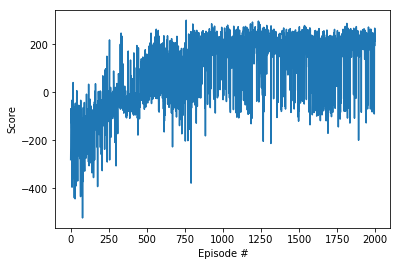

In [11]:
def deep_Q_learning(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        
        state = env.reset()
        score = 0
        
        for t in range(max_t):
            
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon. For more information on the importance of epsilon 
                                          # to an agent's action policy, see the SARSA directory in this Github.
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window)>=200.0:
            
            # a mean score >= 200 represents a solved state. At this point, training has been complete.
            # save the network weights for future testing.
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores

agent = Agent(state_size=8, action_size=4, seed=0)
scores = deep_Q_learning()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch the Smart Agent Land the Spaceship!

The following code will utilize the trained network to successfully land the spaceship within the goal region.

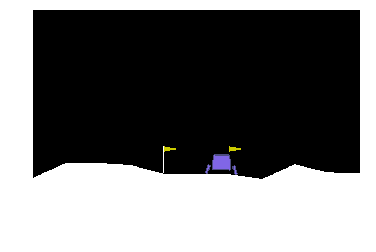

In [12]:
# load the weights from file
agent_test = Agent(state_size=8, action_size=4, seed=0)
agent_test.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(600):
        action = agent_test.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()